In [46]:
# Import statements
from spectral_cube import SpectralCube
from astropy import units as u
from astroquery.splatalogue import Splatalogue
import matplotlib.pyplot as plt
from pylab import imshow
import numpy as np
import scipy.ndimage as nd

In [58]:
# Define functions
def get_line(cube, chemical_name, freq_lo, freq_hi, vel):
    tbl = Splatalogue.query_lines(freq_lo-0.1*u.GHz, freq_hi+0.1*u.GHz, 
                                  chemical_name=chemical_name,
                                  energy_max=500, # more lines w/ max energy > 140
                                  energy_type='eu_k',
                                  line_lists=['JPL'],
                                  show_upper_degeneracy=True, 
                                  show_qn_code=True)
    line_freqs = tbl['Meas Freq-GHz(rest frame,redshifted)'].data
    shifted_line_freqs = line_freqs-((vel/299792)*line_freqs) # Shift by velocity
    tbl['Shifted Freq-GHz'] = shifted_line_freqs
    return tbl

def get_subcube(cube, center_freq, slab_width):
    print(center_freq)
    subcube = cube.spectral_slab(center_freq - 0.1*u.GHz, center_freq + 0.1*u.GHz).to(u.K)
    subcube_v = subcube.with_spectral_unit(u.km/u.s, 
                                           rest_value = center_freq,
                                           velocity_convention = 'radio').spectral_slab(-slab_width,
                                                                                        slab_width)
    print(subcube_v)
    return subcube_v

def get_noise_map(cube_noise):
    cube_sclip = cube_noise.sigma_clip_spectrally(3) # Clip values above 3-sigma 
#     mad_std_spectrum_sclip = cube_sclip.mad_std(axis=(1, 2))
#     plt.plot(mad_std_spectrum_sclip.spectral_axis.value, mad_std_spectrum_sclip.value, drawstyle='steps-mid')
#     plt.xlabel('Velocity (km/s)')
#     plt.ylabel(r' Noise standard deviation $\sigma$ (K)')
#     plt.ylim([0., 0.30]) # Best to extend the range to 0.
#     plt.axhline(0.25, linestyle='--', color='k', linewidth=3, label='A priori noise expectation')
#     plt.legend(frameon=True)
    mad_std_map_sclip = cube_sclip.mad_std(axis=0) # Calculate sigma along the spectral dimension
    return mad_std_map_sclip

def get_signal_mask_scipy(cube_signal, mad_std_map_sclip):
    # Make a low and high mask
    low_snr_mask = (cube_signal > 3 * mad_std_map_sclip).include()
    high_snr_mask = (cube_signal > 10 * mad_std_map_sclip).include()
    low_snr_mask = low_snr_mask.compute() # We need to convert from a dask array to a numpy array.
    high_snr_mask = high_snr_mask.compute()
    # Find connected structures
    structure = np.ones((3, 3, 3), dtype=bool)
    low_snr_mask_labels, num_labels = nd.label(low_snr_mask, structure=structure)
    print(f"Initial number of regions found: {num_labels}")
    # From the labels, count the number of pixels within each label.
    num_pixels_in_high_snr_mask = nd.sum(high_snr_mask,
                                         labels=low_snr_mask_labels,
                                         index=range(1, num_labels + 1)) # +1 offset for mask labels
    # Repeat for the high signal mask.
    num_pixels_in_low_snr_mask = nd.sum(low_snr_mask,
                                        labels=low_snr_mask_labels,
                                        index=range(1, num_labels + 1)) # +1 offset for mask labels
    # To preserve the low_snr_mask, we will create a new signal mask where we will remove 
    # regions that do not pass the criteria.
    signal_mask = low_snr_mask
    low_min_pixels = 40
    high_min_pixels = 10
    for num, (high_pix_num, low_pix_num) in enumerate(zip(num_pixels_in_high_snr_mask, num_pixels_in_low_snr_mask)):
        if high_pix_num >= high_min_pixels and low_pix_num >= low_min_pixels:
            # This region passes the criteria. Keep it in the mask.
            continue
        # Remove regions that do not pass the criteria.
        # NOTE: enumerate will start with 0, but the mask labels start at 1
        # We apply a +1 offset to `num` to account for this.
        signal_mask[low_snr_mask_labels == num + 1] = False
    signal_mask_labels, num_labels = nd.label(signal_mask,
                                              structure=structure)
    print(f"Final number of regions found: {num_labels}")
    signal_mask = nd.binary_dilation(signal_mask, structure=structure, iterations=1)
    return signal_mask

def find_outliers(masked_cube, vel_threshold):
    masked_moment1 = masked_cube.moment1()
    masked_moment1_outliers = (masked_moment1 > vel_threshold*u.km/u.s) | (masked_moment1 < -vel_threshold*u.km/u.s)
    imshow(masked_moment1_outliers, origin='lower') 
    # Clumps of outliers might mean they're real, just outside of vel range

def remove_outliers(masked_cube):
    mom0 = masked_cube.moment0()
    mom0_mask = mom0 > 1.*u.K*u.km/u.s # Mask pixels with mom0 less than threshold
    print(f"Found {mom0_mask.sum()} good pixels")
    masked_cube_no_outliers = masked_cube.with_mask(mom0_mask)
    return masked_cube_no_outliers

In [3]:
# Get cube
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'
freq_spw = '146_spw51'
fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
cube = SpectralCube.read(fn, format='casa_image')
print(cube.shape)

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/casa_formats_io-0.1-py3.7-linux-x86_64.egg/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


(3840, 512, 512)


In [32]:
# Get noise subcube
subcube_noise = get_subcube(cube, 146.8*u.GHz, 15.*u.km/u.s)
spectrum = subcube_noise[:, 256, 256]
plt.plot(spectrum.spectral_axis, spectrum.value)

146.8 GHz
DaskVaryingResolutionSpectralCube with shape=(31, 512, 512) and unit=K and chunk size (31, 128, 128):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:     31  type_s: VRAD      unit_s: km / s  range:      -14.795 km / s:      15.120 km / s


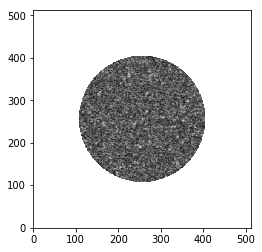

In [39]:
# Get noise map
mad_std_map_sclip = get_noise_map(subcube_noise)
imshow(mad_std_map_sclip.value, cmap='gray', origin='lower')

In [40]:
# Get lines
tbl = get_line(cube, 'CH3CN', 147.01*u.GHz, 147.17*u.GHz, 0)
tbl = tbl[tbl['Quantum Number Code'] == 202]
tbl = tbl[::-1]
tbl.show_in_notebook()

idx,Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Quantum Number Code,Linelist,Shifted Freq-GHz
0,CH3CNv=0,Methyl Cyanide,147.1745883,2e-07,--,--,8(0)-7(0),-2.6575,169.60673,11.02642,-3.7326,--,17.1828,24.72238,22.09202,31.78569,34.0,202,JPL,--
1,CH3CNv=0,Methyl Cyanide,147.1717519,2e-07,--,--,8(1)-7(1),-2.6748,166.91824,10.85164,-3.73957,--,22.1491,31.86782,27.05822,38.931,34.0,202,JPL,--
2,CH3CNv=0,Methyl Cyanide,147.1632441,2e-07,--,--,8(2)-7(2),-2.727,158.99516,10.33654,-3.76076,--,37.047,53.30272,41.95584,60.36548,34.0,202,JPL,--
3,CH3CNv=0,Methyl Cyanide,147.1490683,1e-07,--,--,8(3)-7(3),-2.5156,291.45821,18.94819,-3.79873,--,61.8731,89.02217,66.78146,96.08426,68.0,202,JPL,--
4,CH3CNv=0,Methyl Cyanide,147.1292302,1e-07,--,--,8(4)-7(4),-2.9482,127.19471,8.26914,-3.85798,--,96.6217,139.01798,101.5294,146.07911,34.0,202,JPL,--
5,CH3CNv=0,Methyl Cyanide,147.103738,1e-07,--,--,8(5)-7(5),-3.1316,103.33459,6.71796,-3.94843,--,141.2849,203.27878,146.19175,210.33869,34.0,202,JPL,--
6,CH3CNv=0,Methyl Cyanide,147.0726021,1e-07,--,--,8(6)-7(6),-3.0883,148.38336,9.64665,-4.09259,--,195.8526,281.79004,200.75841,288.84846,68.0,202,JPL,--
7,CH3CNv=0,Methyl Cyanide,147.0358351,1e-07,--,--,8(7)-7(7),-3.7949,39.74307,2.58376,-4.36401,--,260.3123,374.53377,265.21689,381.59042,34.0,202,JPL,--


In [41]:
# Get signal subcube
center_freq = tbl['Freq-GHz(rest frame,redshifted)'][3]*u.GHz
subcube = get_subcube(cube, center_freq, 15.*u.km/u.s)

147.1490683 GHz
DaskVaryingResolutionSpectralCube with shape=(31, 512, 512) and unit=K and chunk size (31, 128, 128):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:     31  type_s: VRAD      unit_s: km / s  range:      -14.888 km / s:      14.956 km / s


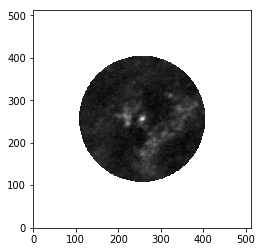

In [48]:
# Look at peak intensity map of signal subcube
peak_intensity_signal = subcube.max(axis=0) # Take the maximum along the spectral dimension
imshow(peak_intensity_signal.value, cmap='gray', origin='lower')

In [51]:
# Get signal mask
signal_mask = get_signal_mask_scipy(subcube, mad_std_map_sclip)
masked_cube = subcube.with_mask(signal_mask)

Initial number of regions found: 1945
Final number of regions found: 5


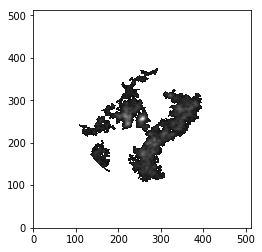

In [52]:
# Look at peak intensity map of masked signal subcube
peak_intensity_sigmask = masked_cube.max(axis=0)
imshow(peak_intensity_sigmask.value, cmap='gray', origin='lower')

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/radio_beam-0.3.3-py3.7.egg/radio_beam/multiple_beams.py:265: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


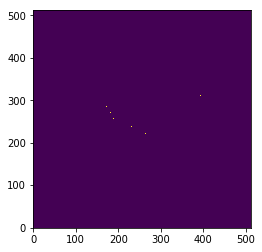

In [55]:
# Visualize outliers
find_outliers(masked_cube, 15.)

In [56]:
# Remove outliers
masked_cube_no_outliers = remove_outliers(masked_cube)

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/radio_beam-0.3.3-py3.7.egg/radio_beam/multiple_beams.py:265: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


Found 17210 good pixels


/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/radio_beam-0.3.3-py3.7.egg/radio_beam/multiple_beams.py:265: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


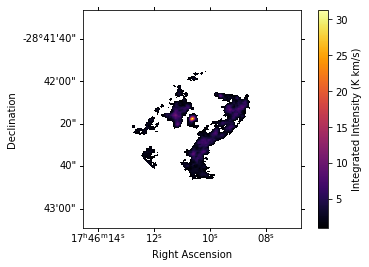

In [57]:
# Moment 0 map
masked_moment0 = masked_cube_no_outliers.moment0()

ax = plt.subplot(projection=masked_moment0.wcs)
im = ax.imshow(masked_moment0.value, origin='lower', cmap='inferno')
cbar = plt.colorbar(im)
cbar.set_label('Integrated Intensity (K km/s)')

ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')
plt.savefig('mom0.pdf')

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/radio_beam-0.3.3-py3.7.egg/radio_beam/multiple_beams.py:265: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


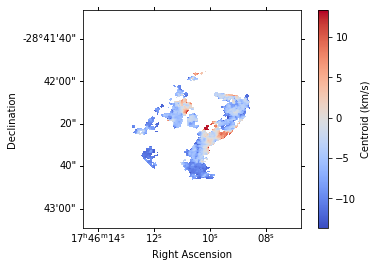

In [59]:
# Moment 1 map
masked_moment1 = masked_cube_no_outliers.moment1()
# masked_moment1[masked_moment1 > 25.*u.km/u.s] = np.nan
# masked_moment1[masked_moment1 < -25.*u.km/u.s] = np.nan

ax = plt.subplot(projection=masked_moment1.wcs)
im = ax.imshow(masked_moment1.value, origin='lower', cmap='coolwarm')
cbar = plt.colorbar(im)
cbar.set_label('Centroid (km/s)')

ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')